In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from brian2_loihi import *

In [2]:
"""
Define some parameters
"""

runtime = 400
n_ex = 400
n_in = 100
p_connectivity = 0.05
n_noise_gens = 40

In [3]:
"""
Define excitatory and inhibitory neuron group
"""

# Excitatory neuron group
group_ex = LoihiNeuronGroup(
    400,
    refractory=2,
    threshold_v_mant=200,
    decay_v=1024,
    decay_I=2048
)

# Inhibitory neuron group
group_in = LoihiNeuronGroup(
    100,
    refractory=2,
    threshold_v_mant=200,
    decay_v=1024,
    decay_I=2048
)

In [4]:
"""
Define input generators and spike times
"""

# Ranomdly generate spikes for noise generators
rand = np.random.rand(n_noise_gens, runtime)

# Define neuron indices and spike times
neuron_indices, spike_times = np.where(rand < 0.05)

# Define spike generators
gen = LoihiSpikeGeneratorGroup(n_noise_gens, neuron_indices, spike_times)

In [5]:
"""
Define functions for drawing connections and lognormal weights
"""

def drawConnections(n_source, n_target, avoid_self=True):
    # Draw random values
    rand = np.random.rand(n_source, n_target)
    # If avoid_self is true, remove diagonal
    # But only apply if n_source = n_target
    if (avoid_self and n_source == n_target):
        np.fill_diagonal(rand, 1)

    # Return sources and targets
    return np.where(rand < p_connectivity)

def drawWeights(sources):
    # Get length of sources
    n = len(sources)
    # Distribution parameters according to Teramae, Tsubo & Fukai (2012)
    m = np.log(0.2) + 1.0
    s = 1.0
    # Draw weight from lognormal distribution
    weights = (np.random.lognormal(m, s, n)*(255/20.)).astype(int)

    # Clip values to meet weight range
    return np.clip(weights, 1, 255)

In [6]:
"""
Define synapses and connect reservoir
"""

# Connect spike generator to ex
sources, targets = np.where(np.random.rand(n_noise_gens, n_ex) < 0.1)
syn_gen = LoihiSynapses(gen, group_ex, sign_mode=synapse_sign_mode.EXCITATORY)
syn_gen.connect(i=sources, j=targets)
syn_gen.w = (np.random.rand(len(sources))*50).astype(int)

# Connect ex ex
sources, targets = drawConnections(n_ex, n_ex)
syn_exex = LoihiSynapses(group_ex, group_ex, sign_mode=synapse_sign_mode.EXCITATORY)
syn_exex.connect(i=sources, j=targets)
syn_exex.w = drawWeights(sources)

# Connect ex in
sources, targets = drawConnections(n_ex, n_in)
syn_exin = LoihiSynapses(group_ex, group_in, sign_mode=synapse_sign_mode.EXCITATORY)
syn_exin.connect(i=sources, j=targets)
syn_exin.w = drawWeights(sources)

# Connect in ex
sources, targets = drawConnections(n_in, n_ex)
syn_inex = LoihiSynapses(group_in, group_ex, sign_mode=synapse_sign_mode.INHIBITORY)
syn_inex.connect(i=sources, j=targets)
syn_inex.w = -drawWeights(sources)

# Connect in in
sources, targets = drawConnections(n_in, n_in)
syn_inin = LoihiSynapses(group_ex, group_in, sign_mode=synapse_sign_mode.INHIBITORY)
syn_inin.connect(i=sources, j=targets)
syn_inin.w = -drawWeights(sources)

In [7]:
"""
Define probes using spike monitors
"""

# Define spike monitors for excitatory neuron group
mon_spike_ex = LoihiSpikeMonitor(group_ex)

In [8]:
"""
Define a network and perform simulation
"""

# NOTE: It is important to use the LoihiNetwork,
#       using Brian's magic network is not provided
net = LoihiNetwork(
    group_ex,
    group_in,
    gen,
    syn_gen,
    syn_exex,
    syn_exin,
    syn_inex,
    syn_inin,
    mon_spike_ex
)

# Run the simulation
net.run(runtime, report='text')

Starting simulation at t=0. s for a duration of 0.4 s


0.4 s (100%) simulated in < 1s


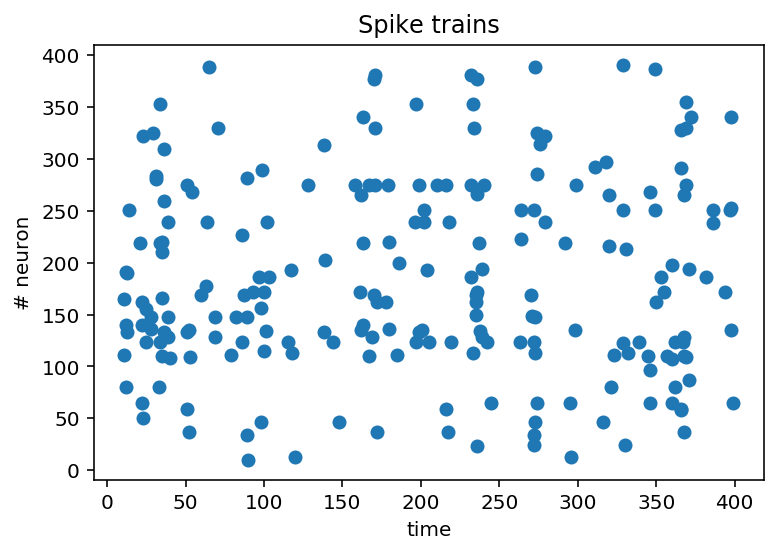

In [10]:
"""
Plot results
"""

# Spikes of excitatory neuron group
plt.scatter(mon_spike_ex.t, mon_spike_ex.i)
plt.title('Spike trains')
plt.xlabel('time')
plt.ylabel('# neuron')
pl = plt.show()